In [ ]:

#from _future_ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import cv2
import sys
import numpy as np
import torch.nn.init
import random
from google.colab.patches import cv2_imshow

use_cuda = torch.cuda.is_available()

In [ ]:
class variables:
  nChannel=100
  maxIter=401
  minLabels=4
  lr=0.1
  nConv=2
  visualize=1
  input="./images/101027.jpg"
  scribble=False
  stepsize_sim=1
  stepsize_con=1
  stepsize_scr=0.5

args=variables()

In [ ]:
# CNN model
class MyNet(nn.Module):
    def __init__(self,input_dim):
        super(MyNet, self).__init__()
        self.conv1 = nn.Conv2d(input_dim, args.nChannel, kernel_size=3, stride=1, padding=1 )
        self.bn1 = nn.BatchNorm2d(args.nChannel)
        self.conv2 = nn.ModuleList()
        self.bn2 = nn.ModuleList()
        for i in range(args.nConv-1):
            self.conv2.append( nn.Conv2d(args.nChannel, args.nChannel, kernel_size=3, stride=1, padding=1 ) )
            self.bn2.append( nn.BatchNorm2d(args.nChannel) )
        self.conv3 = nn.Conv2d(args.nChannel, args.nChannel, kernel_size=1, stride=1, padding=0 )
        self.bn3 = nn.BatchNorm2d(args.nChannel)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu( x )
        x = self.bn1(x)
        for i in range(args.nConv-1):
            x = self.conv2[i](x)
            x = F.relu( x )
            x = self.bn2[i](x)
        x = self.conv3(x)
        x = self.bn3(x)
        return x

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


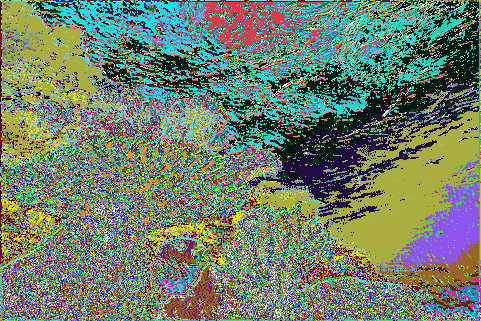

0 / 401 |  label num : 100  | loss : 3.996453046798706


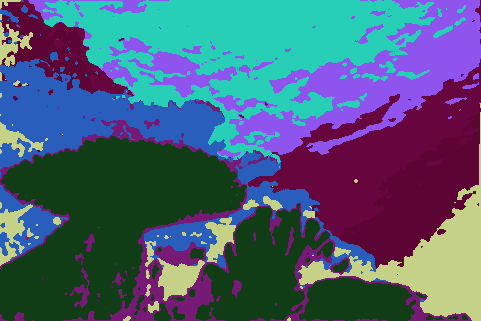

100 / 401 |  label num : 8  | loss : 0.08129733800888062


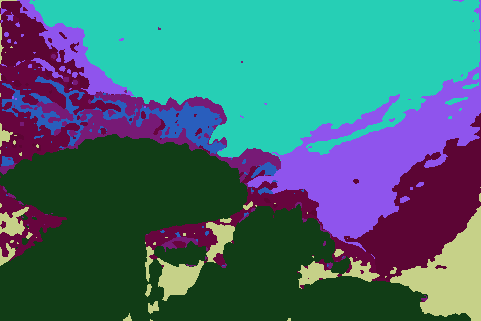

200 / 401 |  label num : 8  | loss : 0.05049712955951691


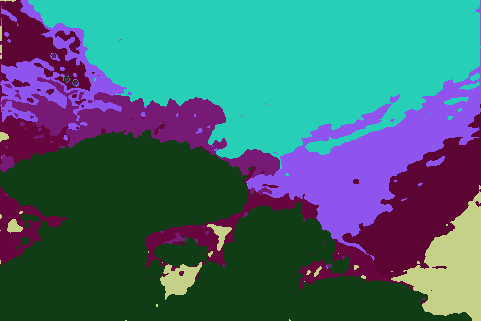

300 / 401 |  label num : 7  | loss : 0.03870644420385361


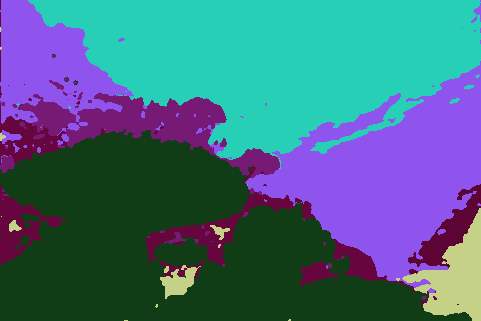

400 / 401 |  label num : 7  | loss : 0.028895709663629532


True

In [ ]:
# load image
im = cv2.imread(args.input)
data = torch.from_numpy( np.array([im.transpose( (2, 0, 1) ).astype('float32')/255.]) )
if use_cuda:
    data = data.cuda()
data = Variable(data)

# train
model = MyNet(data.size(1))
if use_cuda:
    model.cuda()
model.train()

# similarity loss definition
loss_fn = torch.nn.CrossEntropyLoss()

# continuity loss definition
loss_hpy = torch.nn.L1Loss(size_average = True)
loss_hpz = torch.nn.L1Loss(size_average = True)

HPy_target = torch.zeros(im.shape[0]-1, im.shape[1], args.nChannel)
HPz_target = torch.zeros(im.shape[0], im.shape[1]-1, args.nChannel)
if use_cuda:
    HPy_target = HPy_target.cuda()
    HPz_target = HPz_target.cuda()
    
# optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=args.lr, betas=(0.9,0.999), eps=1e-08)
label_colours = np.random.randint(255,size=(100,3))
loss_history = []

for batch_idx in range(args.maxIter):
    # forwarding
    optimizer.zero_grad()
    output = model( data )[ 0 ]
    output = output.permute( 1, 2, 0 ).contiguous().view( -1, args.nChannel )

    outputHP = output.reshape( (im.shape[0], im.shape[1], args.nChannel) )
    HPy = outputHP[1:, :, :] - outputHP[0:-1, :, :]
    HPz = outputHP[:, 1:, :] - outputHP[:, 0:-1, :]
    lhpy = loss_hpy(HPy,HPy_target)
    lhpz = loss_hpz(HPz,HPz_target)

    ignore, target = torch.max( output, 1 )
    im_target = target.data.cpu().numpy()
    nLabels = len(np.unique(im_target))
    if args.visualize:
      if(batch_idx%100 == 0):
        im_target_rgb = np.array([label_colours[ c % args.nChannel ] for c in im_target])
        im_target_rgb = im_target_rgb.reshape( im.shape ).astype( np.uint8 )
        cv2_imshow( im_target_rgb )
        cv2.waitKey(10)

    loss = args.stepsize_sim * loss_fn(output, target) + args.stepsize_con * (lhpy + lhpz)
    loss_history.append(loss.item())    
    loss.backward()
    optimizer.step()
    if(batch_idx%100 == 0):
        print (batch_idx, '/', args.maxIter, '|', ' label num :', nLabels, ' | loss :', loss.item())

    if nLabels <= args.minLabels:
        print ("nLabels", nLabels, "reached minLabels", args.minLabels, ".")
        break

# save output image
if not args.visualize:
    output = model( data )[ 0 ]
    output = output.permute( 1, 2, 0 ).contiguous().view( -1, args.nChannel )
    ignore, target = torch.max( output, 1 )
    im_target = target.data.cpu().numpy()
    im_target_rgb = np.array([label_colours[ c % args.nChannel ] for c in im_target])
    im_target_rgb = im_target_rgb.reshape( im.shape ).astype( np.uint8 )
cv2.imwrite( "output.png", im_target_rgb )

In [ ]:
loss_history

[3.996453046798706,
 3.448152780532837,
 3.0662803649902344,
 2.7245380878448486,
 2.2713818550109863,
 1.8815829753875732,
 1.5463898181915283,
 1.2665475606918335,
 1.0346956253051758,
 0.8658409714698792,
 0.7161101698875427,
 0.6012780666351318,
 0.5096373558044434,
 0.4460296034812927,
 0.3829042613506317,
 0.33721041679382324,
 0.308253675699234,
 0.282941997051239,
 0.26017698645591736,
 0.24273928999900818,
 0.2299671769142151,
 0.21908503770828247,
 0.20917488634586334,
 0.2000754326581955,
 0.19124558568000793,
 0.18489278852939606,
 0.17976891994476318,
 0.1746036410331726,
 0.17049966752529144,
 0.16651301085948944,
 0.1617053747177124,
 0.15658915042877197,
 0.15288898348808289,
 0.148849755525589,
 0.14531806111335754,
 0.14143672585487366,
 0.13810820877552032,
 0.13541041314601898,
 0.13225814700126648,
 0.13017778098583221,
 0.12758752703666687,
 0.12554742395877838,
 0.12332363426685333,
 0.12137487530708313,
 0.11914406716823578,
 0.11697451025247574,
 0.115601256489

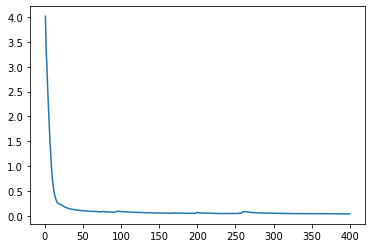

In [ ]:
import matplotlib.pyplot as plt

iters = [i+1 for i in range(400)]
plt.plot(iters, loss_history)